In [2]:
import os
import pickle

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, LogisticRegression

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [3]:
train = pd.read_csv("../Datasets/Train (1).csv")
test = pd.read_csv("../Datasets/Test (1).csv")

In [4]:
test['total_cost'] = -1
full = pd.concat(objs=[train, test], axis=0)
full.drop(columns=['ID', 'payment_mode', 'most_impressing'], axis=1, inplace=True)
full.tail()

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,total_cost
1596,UNITED STATES OF AMERICA,25-44,NaN,0.0,1.0,Meetings and Conference,Mountain climbing,"Newspaper, magazines,brochures",Independent,No,No,No,No,No,No,No,1.0,0.0,No,-1.0
1597,ITALY,45-64,Spouse and Children,3.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Package Tour,No,Yes,Yes,Yes,Yes,No,No,10.0,5.0,Yes,-1.0
1598,FINLAND,25-44,Alone,0.0,1.0,Meetings and Conference,Mountain climbing,"Friends, relatives",Independent,No,No,No,No,No,No,No,6.0,0.0,Yes,-1.0
1599,SOUTH AFRICA,24-Jan,Alone,0.0,1.0,Business,Beach tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,4.0,0.0,Yes,-1.0
1600,SOUTH AFRICA,25-44,Spouse,1.0,1.0,Leisure and Holidays,Cultural tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,9.0,5.0,Yes,-1.0


In [5]:
full['country'] = full['country'].replace({'SWIZERLAND': 'SWITZERLAND',
                                          'UAE': 'UNITED ARAB EMIRATES',
                                          'BURGARIA': 'BULGARIA',
                                          'UKRAIN': 'UKRAINE',
                                          'TRINIDAD TOBACCO': 'TRINIDAD AND TOBAGO',
                                          'COMORO': 'COMOROS',
                                          'COSTARICA': 'COSTA RICA',
                                          'PHILIPINES': 'PHILIPPINES',
                                          'DJIBOUT': 'DJIBOUTI',
                                          'MORROCO': 'MOROCCO', 
                                          'SOMALI': 'SOMALIA', 
                                          'SAUD ARABIA': 'SAUDI ARABIA'})

In [6]:
full.head()

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,total_cost
0,SWITZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,13.0,0.0,No,674602.5
1,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,No,No,No,No,No,No,No,14.0,7.0,Yes,3214906.5
2,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,1.0,31.0,No,3315000.0
3,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,No,Yes,Yes,Yes,Yes,Yes,No,11.0,0.0,Yes,7790250.0
4,CHINA,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,No,No,No,No,No,No,No,7.0,4.0,Yes,1657500.0


In [7]:
countries = pd.read_csv("../Datasets/all.csv")
countries.drop(columns=['alpha-2', 'alpha-3', 'country-code', 'iso_3166-2', 'intermediate-region', 'region-code',
                        'sub-region-code', 'intermediate-region-code'], axis=1, inplace=True)
countries.rename({'name':'country'}, axis=1, inplace=True)
countries.country = countries['country'].str.title()
countries.head()

,country,region,sub-region
0,Afghanistan,Asia,Southern Asia
1,Åland Islands,Europe,Northern Europe
2,Albania,Europe,Southern Europe
3,Algeria,Africa,Northern Africa
4,American Samoa,Oceania,Polynesia


In [8]:
full['country'] = full['country'].str.title()
full['country'].isin(countries['country']).sum()

6317

In [9]:
full = full.merge(countries, how='left')
full.head()

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,total_cost,region,sub-region
0,Switzerland,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,No,...,No,No,No,No,13.0,0.0,No,674602.5,Europe,Western Europe
1,United Kingdom,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,No,...,No,No,No,No,14.0,7.0,Yes,3214906.5,Europe,Northern Europe
2,United Kingdom,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,No,...,No,No,No,No,1.0,31.0,No,3315000.0,Europe,Northern Europe
3,United Kingdom,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,No,...,Yes,Yes,Yes,No,11.0,0.0,Yes,7790250.0,Europe,Northern Europe
4,China,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,No,...,No,No,No,No,7.0,4.0,Yes,1657500.0,Asia,Eastern Asia


In [10]:
train = full[full['total_cost'] != -1]
test = full[full['total_cost'] == -1]

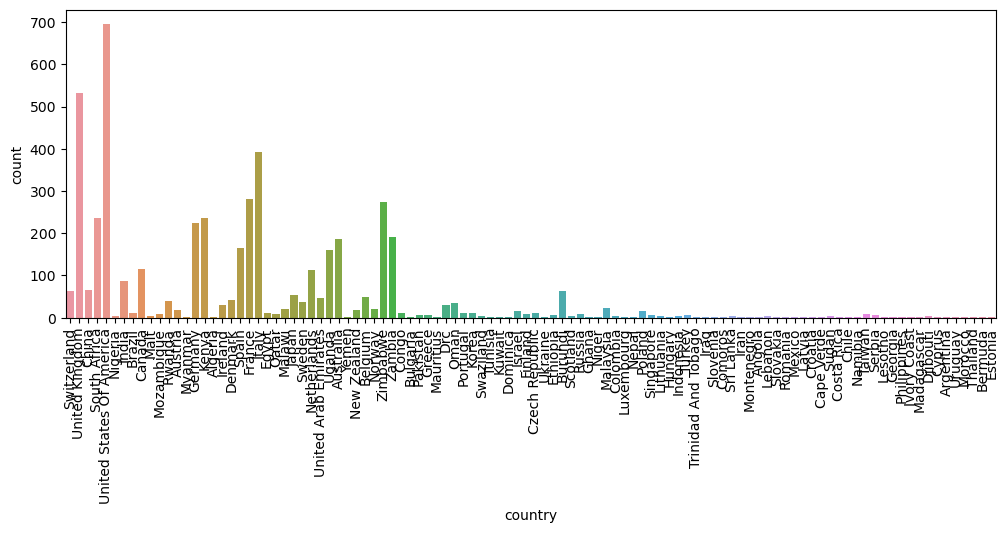

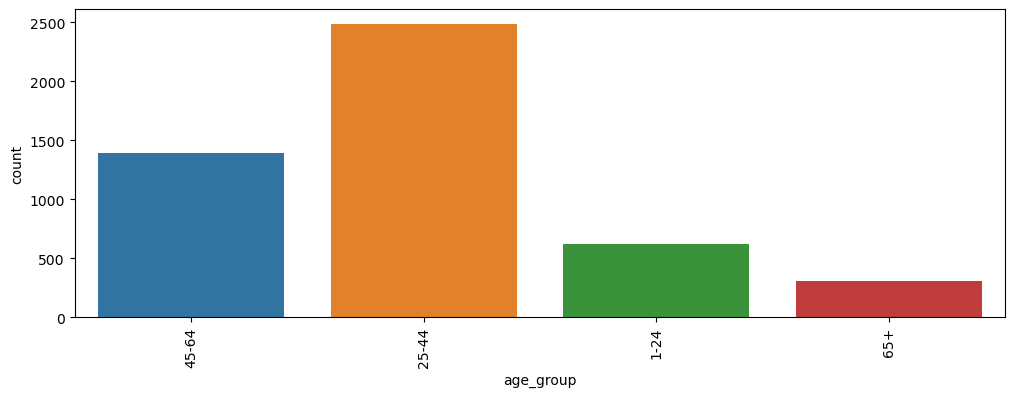

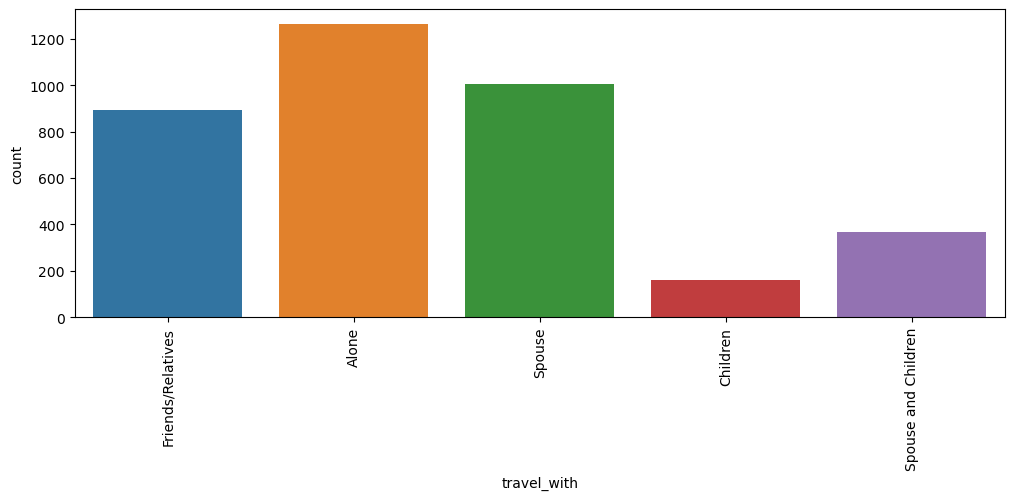

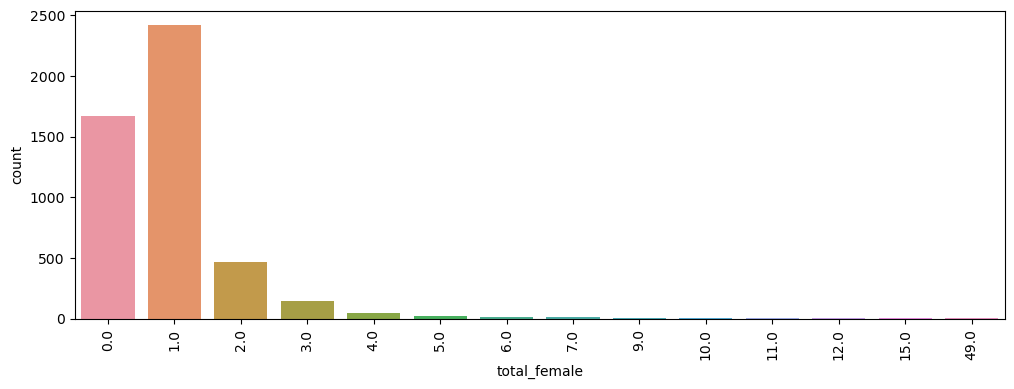

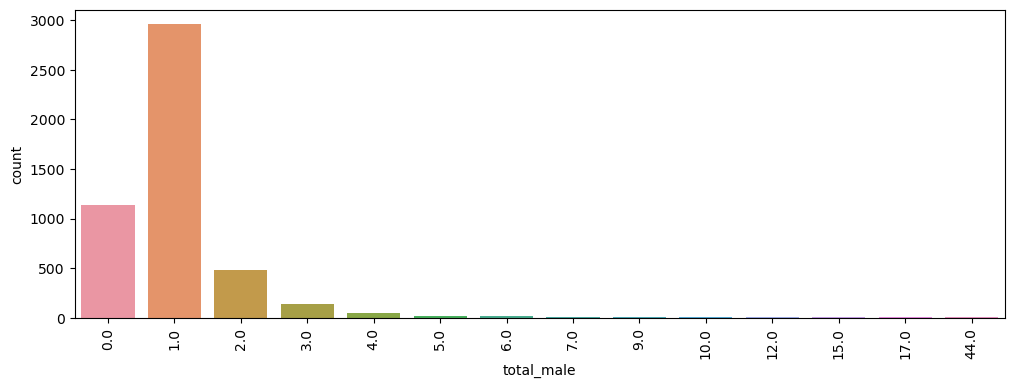

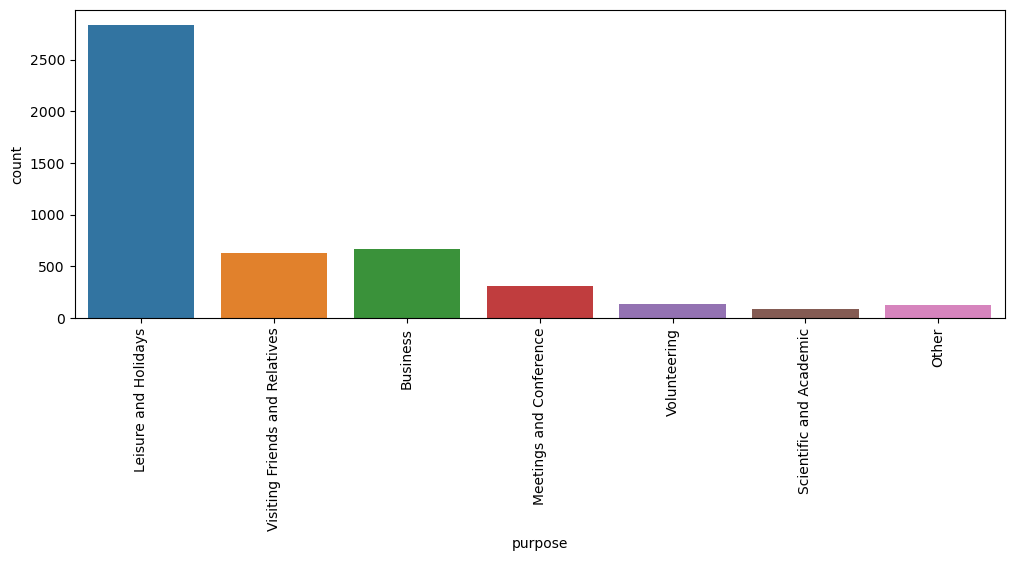

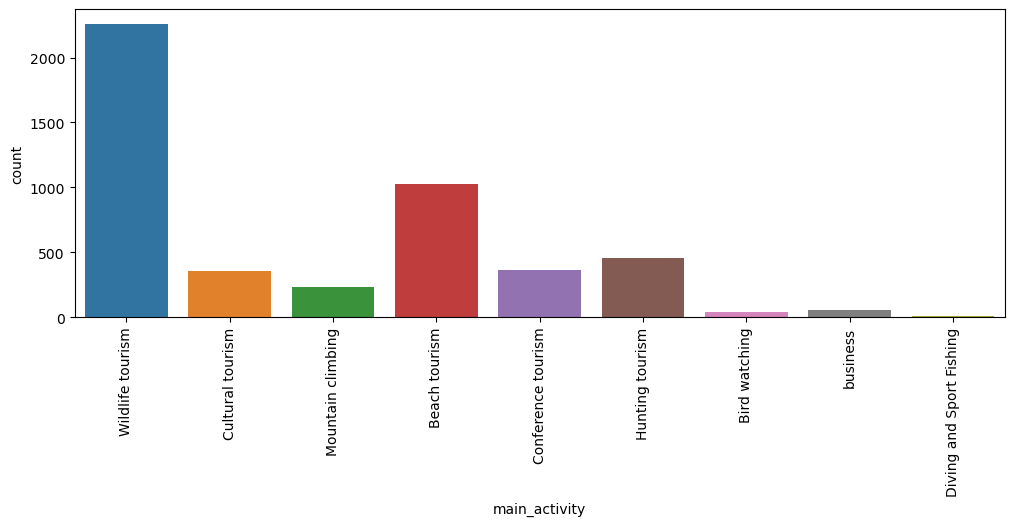

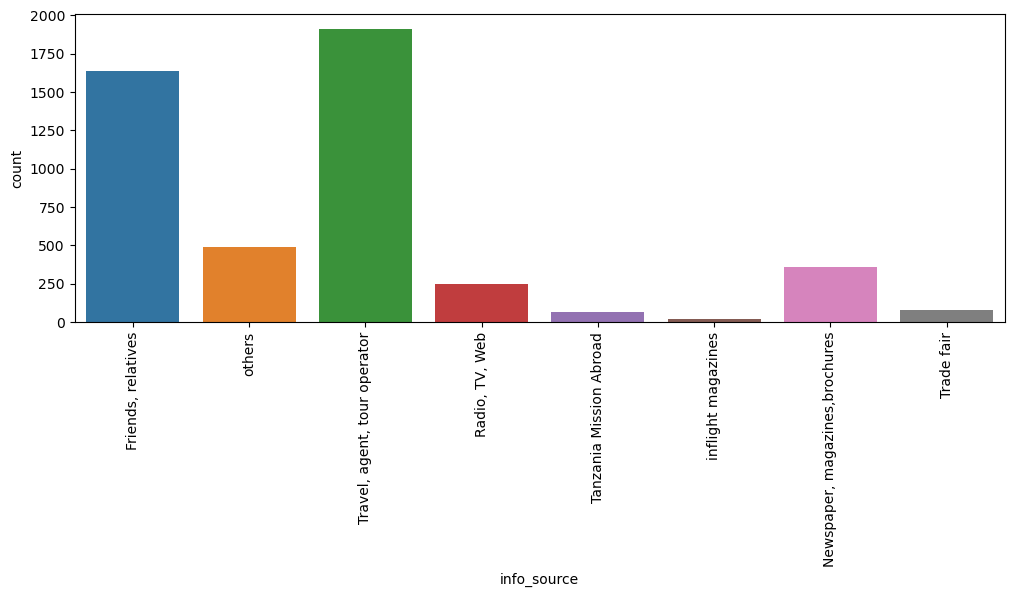

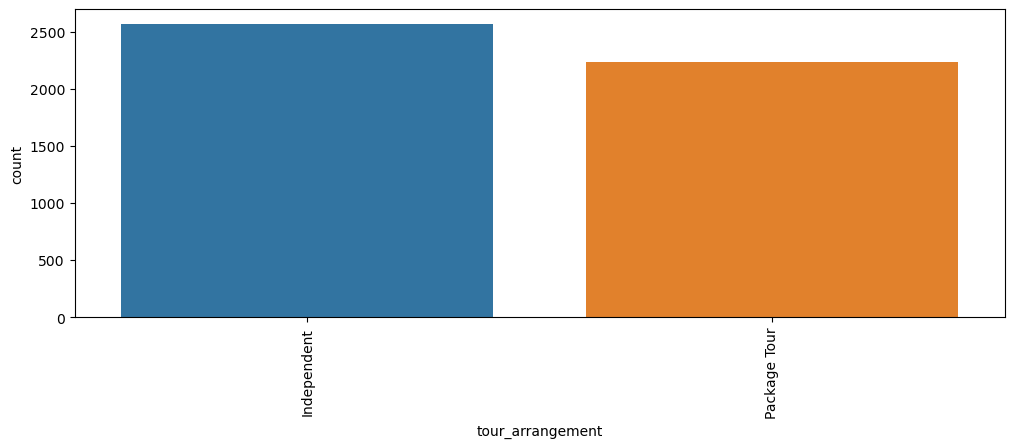

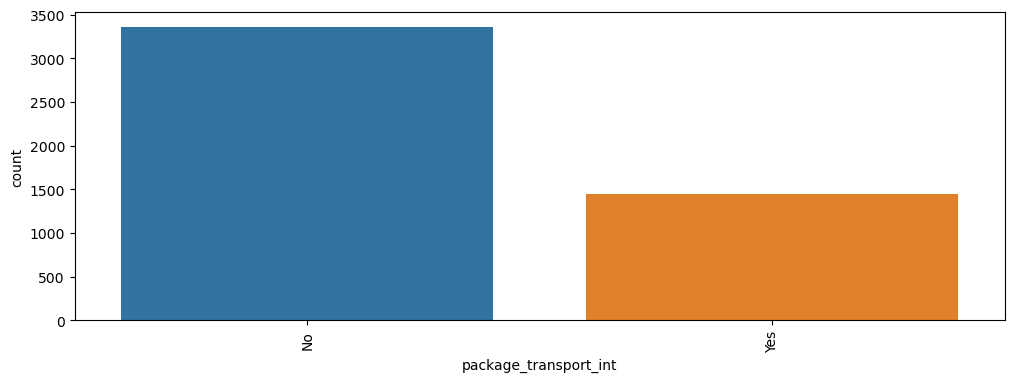

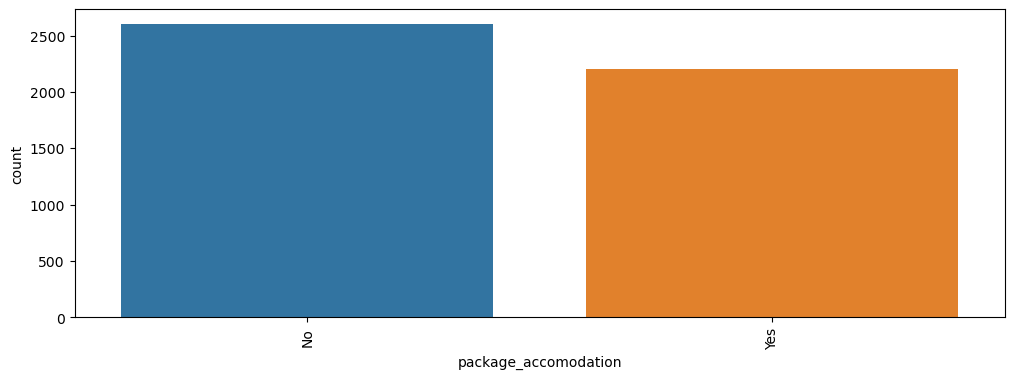

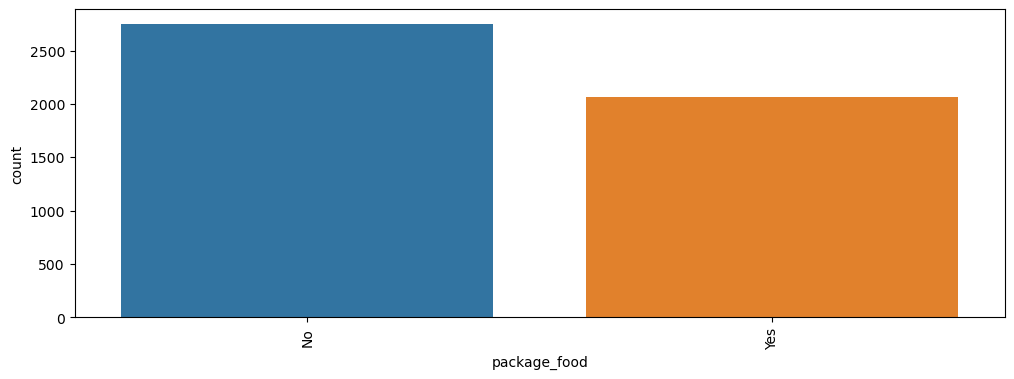

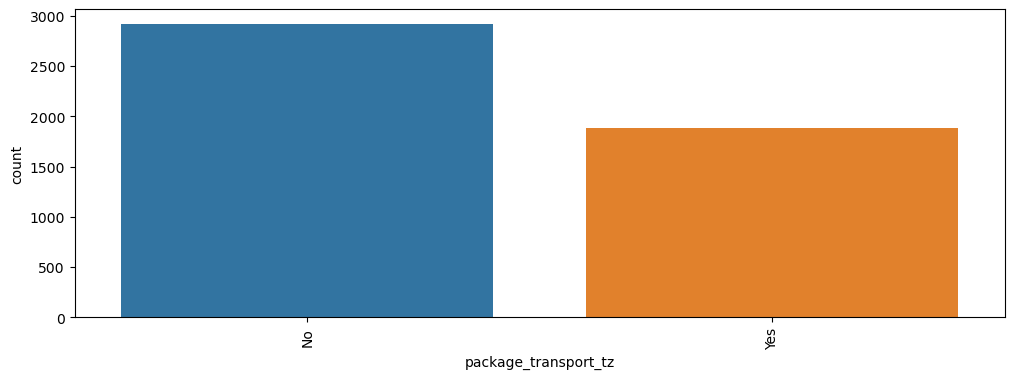

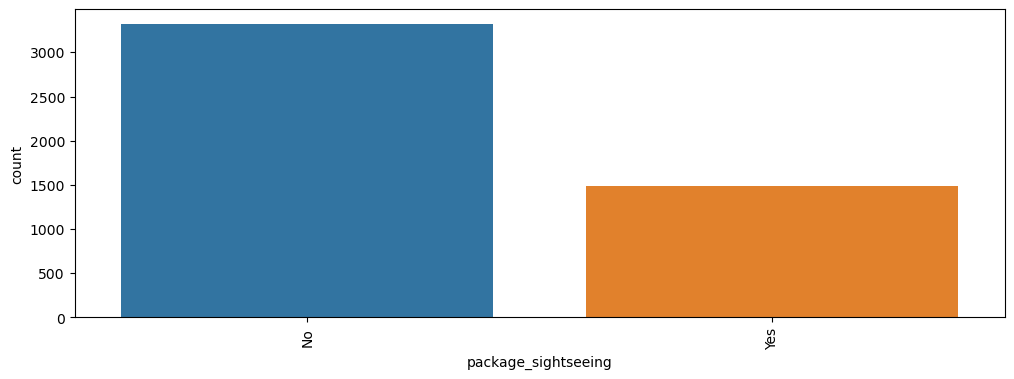

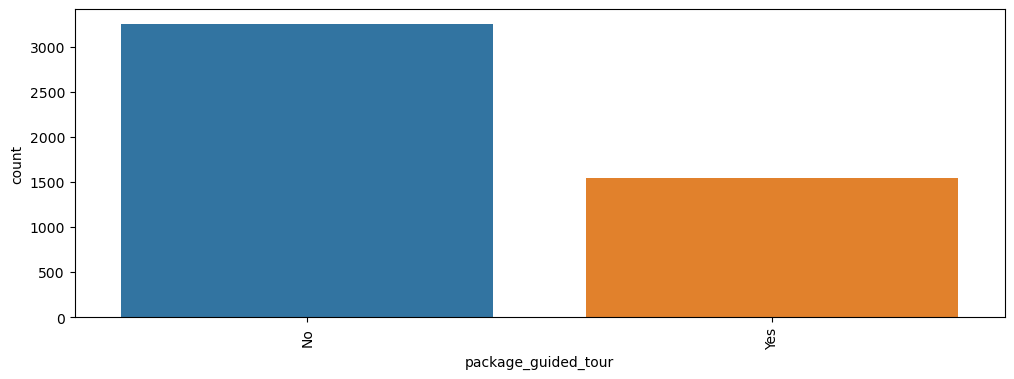

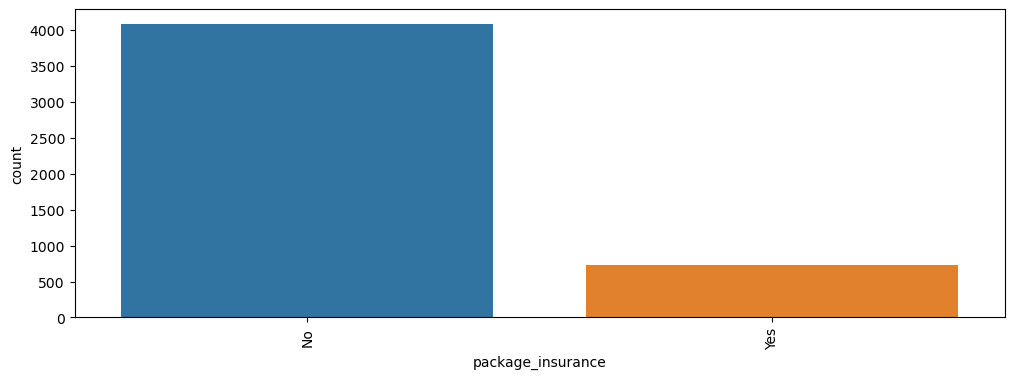

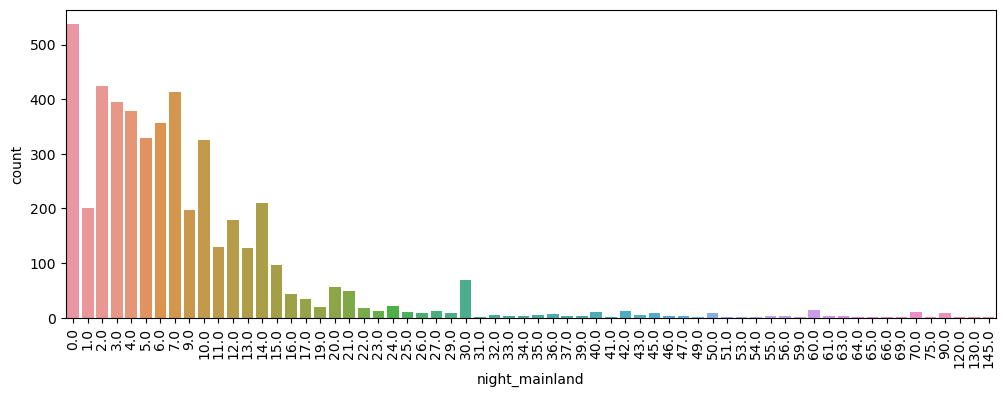

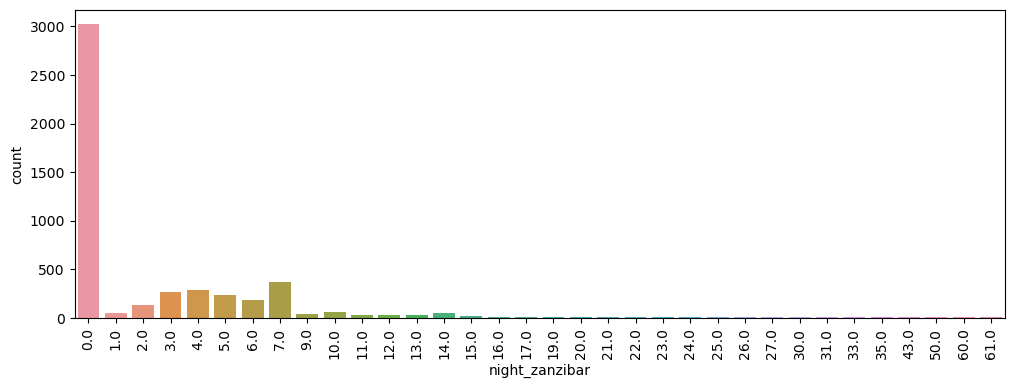

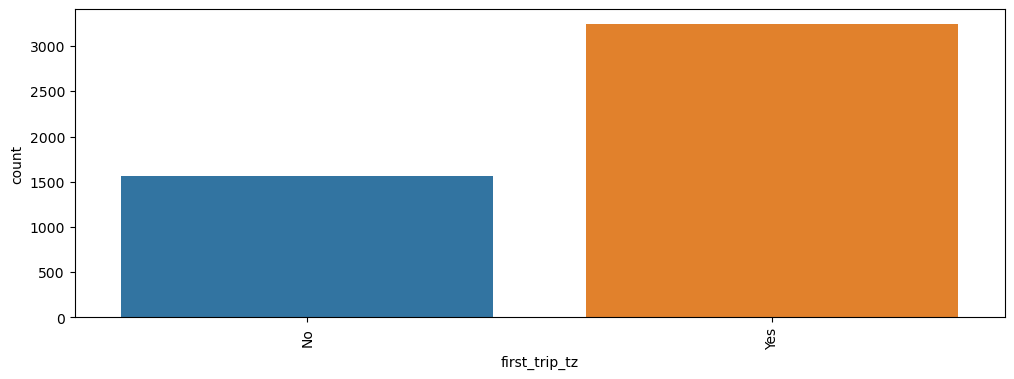

In [11]:
for k in train.columns[:-3]:
    plt.figure(figsize=(12,4))
    plt.xticks(rotation=90)
    sns.countplot(x=k, data=train)

In [12]:
cat = []
for col in train.select_dtypes('object', 'category'):
    cat.append(col)

In [13]:
for col in train.select_dtypes('object', 'category'):
    train.loc[
        train['country'].value_counts()[train['country']].values < 10, "country"
    ] = "RARE"
    
    train.loc[:, col] = train[col].fillna("None").astype(str)

In [14]:
for col in train.select_dtypes('int', 'float'):
    train.loc[:, col] = train[col].fillna(train[col].median)

In [15]:
X = train.drop(['total_cost'], axis=1)
y = train['total_cost']

In [16]:
for col in cat:
    X[col] = X[col].astype('category')

In [17]:
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                   test_size=0.25, random_state=142)

### CatBoost.

In [18]:
CatBoostRegressor??

In [19]:
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.01, max_depth=7,
                          cat_features=cat,
                          loss_function='RMSE',
                          subsample=0.617,
                          reg_lambda=10.0,
                          logging_level='Silent')
model.fit(X_train, y_train)

In [20]:
model.score(X_test, y_test)

0.406404329358955

In [21]:
model.score(X_train, y_train)

0.4930906843048848

In [31]:
y_pred = model.predict(X_test)

In [32]:
import math

mse = mean_squared_error(y_test, y_pred)
mse

94668996665461.64

In [33]:
rmse = math.sqrt(mse)
rmse

9729799.415479315

In [23]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [24]:
mse = mean_squared_error(y_train, y_train_pred)
mse

74029168394078.8

In [25]:
mse = mean_squared_error(y_test, y_test_pred)
mse

94668996665461.64

In [26]:
print('R^2 train: %.3f, test: %.3f' % 
      (r2_score(y_train, y_train_pred), 
       r2_score(y_test, y_test_pred)))

R^2 train: 0.493, test: 0.406


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

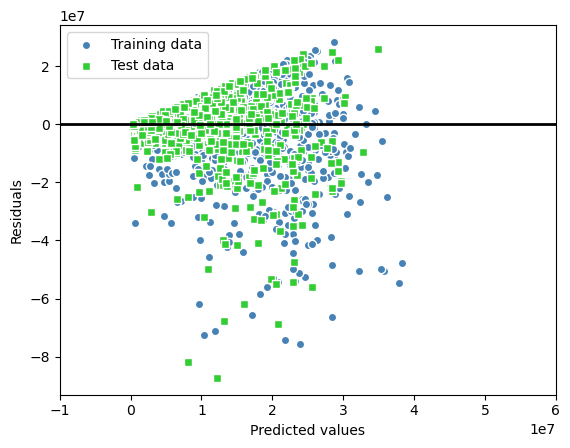

In [27]:
plt.scatter(y_train_pred, y_train_pred - y_train, 
               c='steelblue', marker='o', edgecolor='white', 
               label='Training data')

plt.scatter(y_test_pred, y_test_pred - y_test, 
            c='limegreen', marker='s', edgecolor='white', 
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-1e7, xmax=6e7, color='black', lw=2)
plt.xlim([-1e7, 6e7])
plt.show()

### XGBoost.

In [28]:
import xgboost

d_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
d_test = xgb.DMatrix(X_test, y_test, enable_categorical=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
params = {
    "objective": "reg:squarederror",
    "tree_method":'hist'
}

model = xgb.train(params=params,
                 dtrain=d_train, 
                 num_boost_round=10000,
                 evals=[(d_test, "validation"), (d_train, "train")],
                 verbose_eval=1000, 
                 early_stopping_rounds=50,
                 )

<IPython.core.display.Javascript object>

[0]	validation-rmse:12718764.38558	train-rmse:11978045.32708
[1000]	validation-rmse:11871932.68193	train-rmse:1231146.62174
[2000]	validation-rmse:11901300.90701	train-rmse:1220777.35878
[3000]	validation-rmse:11904064.05508	train-rmse:1220494.91254
[4000]	validation-rmse:11904590.61375	train-rmse:1220476.50646
[5000]	validation-rmse:11904797.95945	train-rmse:1220475.21177
[5520]	validation-rmse:11904816.25281	train-rmse:1220475.12261


In [30]:
y_pred = model.predict(d_test)

mse = mean_squared_error(y_pred, y_test)
mse

141724649685617.9

In [31]:
rmse = math.sqrt(mse)
rmse

11904816.239052912

In [32]:
cross_val = xgb.cv(params=params,
                  dtrain=d_train, 
                  num_boost_round=20000,
                  nfold=10,
                  verbose_eval=1000, 
                  early_stopping_rounds=50
                  )

<IPython.core.display.Javascript object>

[0]	train-rmse:11959235.90781+78795.15839	test-rmse:12225949.17524+840594.43924
[54]	train-rmse:3875476.80121+118317.25650	test-rmse:10206350.89725+750603.57558


In [33]:
cross_val.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.195924e+07,78795.158391,1.222595e+07,840594.439242
1,1.033392e+07,61780.348842,1.093419e+07,811765.523327
2,9.238281e+06,65580.380572,1.021102e+07,785654.520765
3,8.500461e+06,65014.730053,9.872249e+06,804759.016779
4,7.976974e+06,78692.860303,9.668571e+06,758294.815781


In [34]:
cross_val['test-rmse-mean'].min()

9619474.392768215

In [35]:
y_train_pred = model.predict(d_train)
y_test_pred = model.predict(d_test)

print('R^2 train: %.3f, test: %.3f' % 
      (r2_score(y_train, y_train_pred), 
       r2_score(y_test, y_test_pred)))

R^2 train: 0.990, test: 0.111


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

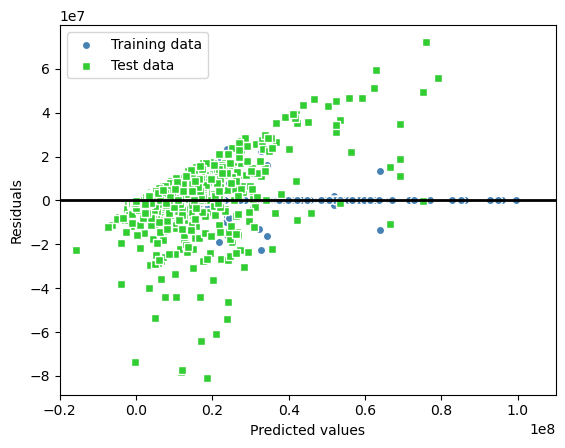

In [36]:
plt.scatter(y_train_pred, y_train_pred - y_train, 
               c='steelblue', marker='o', edgecolor='white', 
               label='Training data')

plt.scatter(y_test_pred, y_test_pred - y_test, 
            c='limegreen', marker='s', edgecolor='white', 
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-2e7, xmax=11e7, color='black', lw=2)
plt.xlim([-2e7, 11e7])
plt.show()

### Part 2

In [37]:
X.shape

(4809, 21)

In [38]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

for col in X.columns:
    if X[col].dtype == 'category':
        if X[col].nunique() <= 10:
            pipe = Pipeline(steps=[
                ("encoder", OneHotEncoder(sparse_output=False)),
                ("imputer", SimpleImputer(strategy='median')),
                ("poly", PolynomialFeatures(3))
            ])
            pipe.fit_transform(X[col][:, np.newaxis]).flatten()
        else:
            pipe = Pipeline(steps=[
                ("onehot",OrdinalEncoder())
            ])
            pipe.fit_transform(X[col][:, np.newaxis]).flatten()
    else:
        pipe = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy='median')),
            ("scaler", StandardScaler())
        ])
        pipe.fit_transform(X[col][:, np.newaxis]).flatten()

pipe.set_output(transform='pandas')
xx = pipe.fit_transform(X)

In [39]:
xx.shape

(4809, 21)

In [40]:
xx.head()

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,region,sub-region
0,34.0,2.0,2.0,1.0,1.0,1.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,3.0,13.0
1,37.0,1.0,3.0,1.0,0.0,1.0,3.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.0,7.0,1.0,3.0,7.0
2,37.0,1.0,0.0,0.0,1.0,5.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,27.0,0.0,3.0,7.0
3,37.0,1.0,4.0,1.0,1.0,1.0,7.0,5.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,10.0,0.0,1.0,3.0,7.0
4,6.0,0.0,3.0,1.0,0.0,1.0,7.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,4.0,1.0,2.0,1.0


In [41]:
X_train, X_test, y_train, y_test = train_test_split(xx, y,
                                                   test_size=0.3, random_state=142)

### Random Forest

In [42]:
rf = RandomForestRegressor(n_estimators=500,
                           max_depth=5,
                           criterion='squared_error',
                           n_jobs=-1,
                           random_state=142)
rf.fit(X_train, y_train)

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

In [ ]:
rmse = math.sqrt(mse)
rmse

In [ ]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print('R^2 train: %.3f, test: %.3f' % 
      (r2_score(y_train, y_train_pred), 
       r2_score(y_test, y_test_pred)))

In [ ]:
plt.scatter(y_train_pred, y_train_pred - y_train, 
               c='steelblue', marker='o', edgecolor='white', 
               label='Training data')

plt.scatter(y_test_pred, y_test_pred - y_test, 
            c='limegreen', marker='s', edgecolor='white', 
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-1e7, xmax=5e7, color='black', lw=2)
plt.xlim([-1e7, 5e7])
plt.show()

In [ ]:
f_importances = pd.Series(rf.feature_importances_, index=xx.columns)
f_importances = np.argsort(f_importances)
f_importances

In [ ]:
col_names = xx.columns
f_importances = pd.Series(rf.feature_importances_, index=col_names)
#idxs = np.argsort(importances)
plt.title('Feature Importances')
f_importances.nlargest(20).plot(kind='barh').invert_yaxis();
#plt.barh(X_train.shape[1], importances[idxs], align='center')
#plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
#import shap

perm_imp = permutation_importance(rf, X_test, y_test)
sorted_imp = perm_imp.importances_mean.argsort()
sorted_imp[:20]

In [ ]:
sorted_imp = sorted_imp[:20]
sorted_imp

In [ ]:
plt.barh(perm_imp.importances_mean[sorted_imp])

### XGBOOST

In [ ]:
xgb.XGBRegressor??

In [ ]:
from xgboost import XGBRegressor

#gblinear, dart,
xgb = XGBRegressor(n_estimators=1000, max_depth=8,
                      grow_policy="depthwise", learning_rate=0.1,
                      booster="gbtree", gamma=0.1,
                      subsample=0.367, reg_lambda=10.0,
                      importance_type="weight", random_state=142)

In [ ]:
xgb.fit(X_train, y_train)

In [ ]:
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

In [ ]:
rmse = math.sqrt(mse)
rmse

In [ ]:
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

print('R^2 train: %.3f, test: %.3f' % 
      (r2_score(y_train, y_train_pred), 
       r2_score(y_test, y_test_pred)))

In [ ]:
plt.scatter(y_train_pred, y_train_pred - y_train, 
               c='steelblue', marker='o', edgecolor='white', 
               label='Training data')

plt.scatter(y_test_pred, y_test_pred - y_test, 
            c='limegreen', marker='s', edgecolor='white', 
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-1e7, xmax=5e7, color='black', lw=2)
plt.xlim([-1e7, 5e7])
plt.show()

### LGBM

In [ ]:
lgb = LGBMRegressor(n_estimators=1000,
                    boosting_type='gbdt',
                    objective='regression',
                    learning_rate=0.01,
                    reg_lambda=10.0,
                    subsample=0.645,
                    num_leaves=16, 
                    max_depth=8, 
                    random_state=142)

In [ ]:
lgb.fit(X_train, y_train)

In [ ]:
y_pred = lgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

In [ ]:
rmse = math.sqrt(mse)
rmse

In [ ]:
y_train_pred = lgb.predict(X_train)
y_test_pred = lgb.predict(X_test)

print('R^2 train: %.3f, test: %.3f' % 
      (r2_score(y_train, y_train_pred), 
       r2_score(y_test, y_test_pred)))

In [ ]:
plt.scatter(y_train_pred, y_train_pred - y_train, 
               c='steelblue', marker='o', edgecolor='white', 
               label='Training data')

plt.scatter(y_test_pred, y_test_pred - y_test, 
            c='limegreen', marker='s', edgecolor='white', 
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-1e7, xmax=5e7, color='black', lw=2)
plt.xlim([-1e7, 5e7])
plt.show()

In [ ]:
col_names = train.columns

In [ ]:
importances = pd.Series(lgb.feature_importances_, xx.columns)
idxs = np.argsort(importances)
plt.title('Feature Importances')
importances.nlargest(20).plot(kind='barh').invert_yaxis();
#plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

In [ ]:
test.head()

In [ ]:
test.drop(columns=['total_cost'], axis=1, inplace=True)
test[90:105]

In [ ]:
cat = test.select_dtypes(exclude=np.number).columns.tolist()

for col in cat:
    test[col] = test[col].astype('category')

In [ ]:
model.predict(xgb.DMatrix(test[90:105], enable_categorical=True))